In [1]:
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot
from sklearn import metrics
from matplotlib import pyplot

In [2]:
url = 'https://raw.githubusercontent.com/leilaff89/house_sales_prediction/main/datasets/house_prices_no_null.csv'

In [3]:
mld = pd.read_csv(url)

In [4]:
dummie = pd.get_dummies(mld[['SUBURB','NEAREST_STN','NEAREST_SCH']])
mld = mld.join(dummie)
mld = mld.drop(columns=['ADDRESS','LATITUDE','LONGITUDE','SUBURB','NEAREST_STN','NEAREST_SCH'])

In [5]:
mld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19174 entries, 0 to 19173
Columns: 468 entries, PRICE to NEAREST_SCH_WOODVALE SECONDARY COLLEGE
dtypes: float64(3), int64(11), uint8(454)
memory usage: 10.3 MB


In [6]:
mld.head()

,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,...,NEAREST_SCH_SWAN CHRISTIAN COLLEGE,NEAREST_SCH_SWAN VALLEY ANGLICAN COMMUNITY SCHOOL,NEAREST_SCH_THORNLIE SENIOR HIGH SCHOOL,NEAREST_SCH_TRANBY COLLEGE,NEAREST_SCH_TRINITY COLLEGE,NEAREST_SCH_URSULA FRAYNE CATHOLIC COLLEGE,NEAREST_SCH_WANNEROO SECONDARY COLLEGE,NEAREST_SCH_WESLEY COLLEGE,NEAREST_SCH_WILLETTON SENIOR HIGH SCHOOL,NEAREST_SCH_WOODVALE SECONDARY COLLEGE
0,365000,3,2,2.0,351,139,2013,26900,4900,6167,...,0,0,0,0,0,0,0,0,0,0
1,287000,3,1,1.0,719,86,1979,22600,1900,6111,...,0,0,0,0,0,0,0,0,0,0
2,685000,3,2,8.0,552,126,1999,5900,508,6053,...,0,0,0,0,0,0,0,0,0,0
3,367500,3,2,2.0,398,158,2003,36300,2100,6036,...,0,0,0,0,0,0,0,0,0,0
4,535000,4,2,4.0,704,247,2002,23100,3900,6164,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = mld.drop(columns=['PRICE'],axis =1).values
y = mld['PRICE'].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)

In [9]:
def get_models():
    models = dict()
    models['knn'] = KNeighborsRegressor()
    models['ann'] = MLPRegressor()
    models['dt'] = DecisionTreeRegressor()
    models['svm'] = SVR()
    return models

In [10]:
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>lr -23585099842274364.000 (35571892635757420.000)
>ann -351922.879 (12968.270)
>dt -130577.573 (2659.513)
>svm -273602.245 (7092.597)


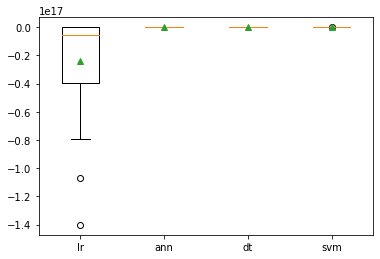

In [11]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
print('MSE:', metrics.mean_squared_error(y_test, y_pred))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100), random_state=1, max_iter=300, verbose=True).fit(X_pca_Train, y_train)

In [ ]:
X_pca_Test = pca.transform(X_test)
clf.score(X_pca_Test,y_test)